In [5]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

previous_filename = "gd1_redux_01.hdf5"
results_t = Table.read(previous_filename, path="initial_selection")
icrs_corners_t = Table.read(previous_filename, path="ircs_corners")
icrs_corners=SkyCoord(icrs_corners_t['ra'], icrs_corners_t['dec'], frame="icrs")


<module 'matplotlib.pyplot' from '/home/adamarthurryan/micromamba/envs/jupyter/lib/python3.13/site-packages/matplotlib/pyplot.py'>

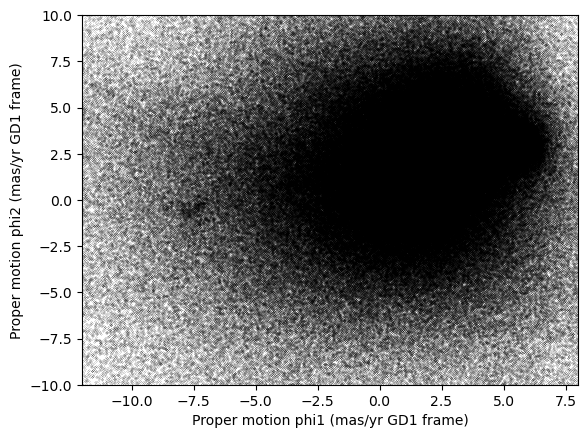

In [6]:
from common import plot_proper_motion 
plot_proper_motion(results_t)

<module 'matplotlib.pyplot' from '/home/adamarthurryan/micromamba/envs/jupyter/lib/python3.13/site-packages/matplotlib/pyplot.py'>

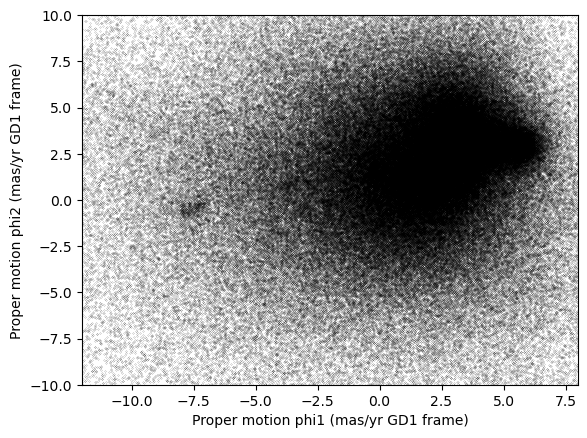

In [7]:
# filter results to within +/- 2 degree of the centerline in GD1 frame

# get the phi2 series
phi2 = results_t["phi2"]

# create a mask of values in range of +/- 1 deg from centerline
phi2_range = (-3.0*u.degree, 3.0*u.degree)
mask = (phi2 > phi2_range[0]) & (phi2 < phi2_range[1])

# filter the results
centerline_t = results_t[mask]

#centerline_df.describe()
plot_proper_motion(centerline_t)

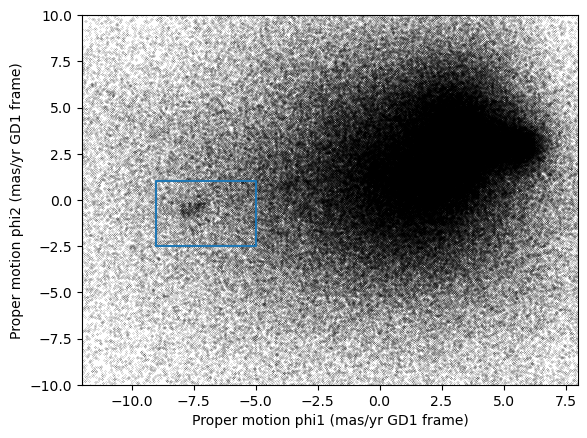

In [17]:
# the overdense region around (-7.5, 0.0) is now more clear
# select it with a rectangle
########

from common import make_rectangle, is_between

import matplotlib.pyplot as plt

pm1_range = (-9,-5)
pm2_range = (-2.5, 1.0) 
pm1_rect, pm2_rect = make_rectangle(pm1_range, pm2_range)

plot_proper_motion(centerline_t)
plt.plot(pm1_rect, pm2_rect, '-')

# create the selection table 
pm1 = results_t['pm_phi1']
pm2 = results_t['pm_phi2']

mask = is_between(pm1, pm1_range) & is_between(pm2, pm2_range)
selection_t = results_t[mask]

#plot_proper_motion(selection_t, "gx")


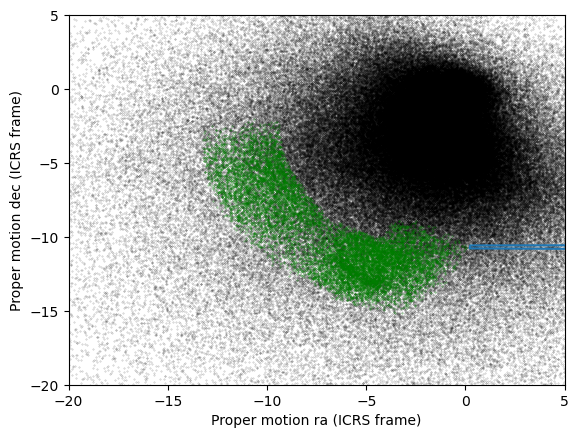

In [20]:
# now find a concave hull around the ICRS coordinates for this selection
#########

from shapely.geometry import MultiPoint
from shapely import concave_hull 

points = selection_t[['pmra', 'pmdec']].to_pandas().to_numpy()
multipoint = MultiPoint(points)

hull = concave_hull(multipoint, ratio=0.5)
pmra, pmdec=hull.exterior.coords.xy

#the pmra values need to be in the range 0..360
pmra=list(map(lambda n: n if n>0 else n+360, pmra))
pm_vertices_t = Table([pmra, pmdec], names=['pmra', 'pmdec'])

x=centerline_t['pmra']
y=centerline_t['pmdec']
plt.plot(x,y, "ko", markersize=.3, alpha=.3)

x=selection_t['pmra']
y=selection_t['pmdec']
plt.plot(x,y, 'gx', markersize=1, alpha=.3)

pmra_poly = pm_vertices_t['pmra']
pmdec_poly = pm_vertices_t['pmdec']
plt.plot(pmra_poly, pmdec_poly)

plt.xlabel("Proper motion ra (ICRS frame)")
plt.ylabel("Proper motion dec (ICRS frame)")
plt.xlim([-20, 5])
plt.ylim([-20, 5]);


In [6]:
# download a script for reading MIST models (surely there is a package that could do this?)
#########

# from common import download
# download('https://github.com/jieunchoi/MIST_codes/raw/master/scripts/' +
#         'read_mist_models.py')


In [21]:
# and read the model to create an isochrone
########

import read_mist_models

filename = 'MIST_iso_689d45a79137f.iso.cmd'
iso = read_mist_models.ISOCMD(filename)
iso_array = iso.isocmds[0]

# select stars in main sequence and red giant phases 0<=phase<3
phase = iso_array['phase']
phase_mask = (phase>=0) & (phase<3)
iso_main_sequence = iso_array[phase_mask]
len(iso_main_sequence)

Reading in: MIST_iso_689d45a79137f.iso.cmd


354

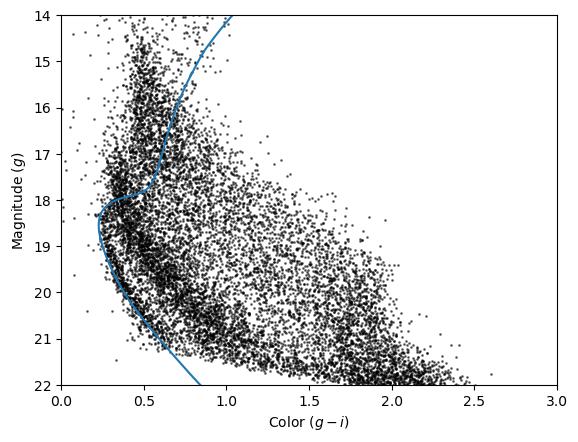

In [22]:
# apply distance modulus to isochrone to scale magnitudes to match GD-1
##########

import astropy.coordinates as coord
import astropy.units as u 
from astropy.table import Table
from common import plot_cmd

distance = coord.Distance(7.8 * u.kpc)
distmod =  distance.distmod.value

mag_g = iso_main_sequence['PS_g'] + distmod
color_gi = iso_main_sequence['PS_g'] - iso_main_sequence['PS_i']

isochrone = Table([mag_g, color_gi], names=('mag_g', 'color_gi'))

plot_cmd(selection_t)
plt.plot(color_gi, mag_g)

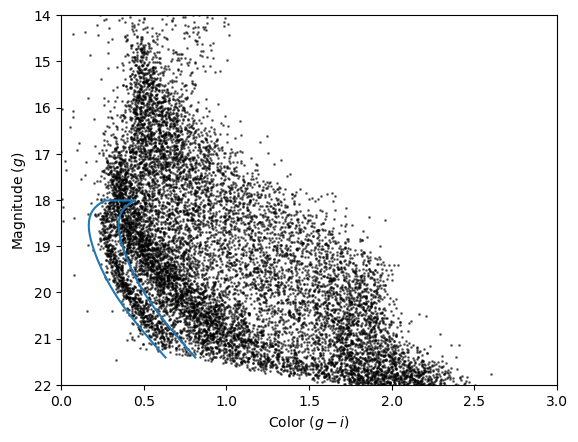

In [23]:
from common import polygon

# select the part of the isochrone that lies in the overdense region
mag_g = isochrone['mag_g']
g_mask = (mag_g > 18.0) & (mag_g <21.5)
iso_masked = isochrone[g_mask]

# create a polygon to select a region around the isochrone
color_gi = iso_masked['color_gi']
mag_g = iso_masked['mag_g']
color_left = color_gi - 0.06
color_right = color_gi + 0.12

color_polygon = polygon(color_left, color_right)
mag_polygon = polygon(mag_g, mag_g)
cm_polygon_t = Table([color_polygon, mag_polygon], names=['color_gi', 'mag_g'])

plot_cmd(selection_t)
plt.plot(color_polygon, mag_polygon)

In [24]:
# save the data
########

filename = "gd1_redux_02.hdf5"
cm_polygon_t.write(filename, path="cm_polygon", serialize_meta=True, overwrite=True)
pm_vertices_t.write(filename, path='pm_vertices',serialize_meta=True, append=True)
icrs_corners.to_table().write(filename, path="ircs_corners", serialize_meta=True, append=True)

